# Exploring the Distributions of Salaries for NBA Teams over Time and in Relation to Wins

## Background
Andecdote about the Miami heat big 3. Throw out a hypothesis.

## Themes to explore
- Change in distribution over time for all teams
- Change in distribution over time for successful teams
- Number of teams over a certain distribution threshold per year

## Outline

1. scrape/save data
    - years
        - teams
            - wins each year
            - total salary of teams each year
            - list of players on team each year
                - salary of player
2. build pandas frames from data
3. clean data if necessary (maybe before build data frames)
4. draw charts?

## Retrospective - How does it flow and how can I regroup them?
Scrape and save soup for year, team, players

Parse soup for year, team, player

Build JSON from parsed soup

Maybe have a scraper with that gets the soups (but cant totally seperate this from parsing years/teams)

## Get Data

This section should only be run once to scrape and save the data to prevent making too many unecessary requests.

1. Get list of teams from stats.nba.com or something
2. Make team object (team name, list of players)
3. Fill team object with list of players
4. Make each player object (team, salary)
5. Get salary from https://hoopshype.com/salaries/indiana_pacers/

In [36]:
from bs4 import BeautifulSoup
import requests
import json
import os
from time import sleep

### Retrieve base HTML which contains all the years

I made functions for getting, saving and loading soup objects that we will use whenever we scrape and parse data. By saving the soup to file we will avoid having to re-scrape the site to get the page into memory. Putting `sleep()` in `getSoup()` ensures we make requests too quickly later when we are scraping lots of different urls and retrying requests.

In [37]:
def getSoup(url):
    page = requests.get(url)
    sleep(1)
    return BeautifulSoup(page.content, 'html.parser')

In [38]:
def saveSoup(filePath):
    path = filePath.rpartition('/')[0] # == 'parent/child' for 'parent/child/file.txt'
    
    if not os.path.exists(path):
        os.makedirs(path)

    with open(filePath, 'w', encoding='utf-8') as fp:
            fp.write(str(soup))

In [39]:
def loadSoup(filePath):
    with open(filePath, 'rb') as html:
        return BeautifulSoup(html)

In [231]:
soup = getSoup('https://hoopshype.com/salaries')
saveSoup(f'data/soups/base.html')

The website displays the year in a format like `2019/20` but the URL uses the format `2019-2020`. So before saving the date we will transform it to this new format. Since I will use this several times I will write a function.

In [40]:
def toLongYearFormat(shortYear):
    '''converts from format like 2019/20 to format like 2019-2020'''
    longYear = shortYear.replace("/","-")
    
    firstTwo = shortYear[:2] #20 from 2019
    lastTwo = shortYear[2:4] #19 from 2019
    
    indexToInsert = longYear.find("-") + 1
    
    if lastTwo != '99':
        longYear = longYear[:indexToInsert] + firstTwo  + longYear[indexToInsert:]
    else:
        newFirstTwo = str(int(firstTwo) + 1)
        longYear = longYear[:indexToInsert] + newFirstTwo  + longYear[indexToInsert:]
        
    return longYear

### Get the years from base HTML, save to JSON, and save soup and data
As we parse data at the different levels (years, teams of years, players of teams) we will save to our main data object. I am using JSON. To make this easier I am making save and load functions.

In [41]:
def saveData(data):
    with open('data/nbaSalaryData.json', 'w') as fp:
        json.dump(data, fp, indent=4)

In [42]:
def loadData():
    with open('data/nbaSalaryData.json', 'r') as fp:
        return json.load(fp)

In [295]:
# parse
#first two links are duplicate
soup = loadSoup('data/soups/base.html')
yearLinks = soup.find('li', class_='all').find_all('a')[1:]
yearStrings = []

# strip
for year in yearLinks:
    txt = toLongYearFormat(year.text.strip())
    yearStrings.append(txt)
        
#sort from low year to high year, and fill dict
yearStrings.sort()
currentYear = yearStrings[-1]

#start data object
nbaSalaryData = dict.fromkeys(yearStrings)

#save data
saveData(nbaSalaryData)

saveSoup(f'data/soups/{currentYear}/{currentYear}.html')

### Crawl for each year and save HTML
I chose to save the HTML pages and wait 1 second between requests because we will be making a request for each year. I do not want to make many requests in quick succession nor make the same requests again in the future unless I expect that the data has actually changed.

Occasionally scraping a year works but the teams don't populate in the table. To deal with this, I check the number of teams in the table. When the table of teams doens't populate I retry the request a limited number of times, and print the year that has failed with the number of retry attempts. If all retries fail they have to be manually scraped.

In [43]:
def soupIsValid(soup):
    # more than 1 td element wtih name class when
    return len(soup.find_all('td', class_='name')) > 1

In [271]:
nbaSalaryData = loadData()

# past years only because current year was saved earlier
pastYears = list(nbaSalaryData.keys())[:-1]

for year in pastYears:
    soup = getSoup(f'https://hoopshype.com/salaries/{year}/')
    
    if not soupIsValid(soup):
        print(f'soup retreived for year {year} is not valid')
        for n in range(5):
            print(f'retrying {n}')
            soup = getSoup(url)
    
    #save soup to .html file
    saveSoup(f'data/soups/{year}/{year}.html')

### Get the teams and team salary from each year and add to JSON object

In [303]:
# load data and soup files
nbaSalaryData = loadData()
yearFiles = ([f'{x[0]}/{x[2][0]}' for x in list(os.walk("data/soups"))[1:]])

# add teams to year data for each year
for f in yearFiles:
    soup = loadSoup(f)
    year = f.split("/")[-1].split('.')[0]
    
    # assign empty object so we can assign object with 'nbaSalaryData[year][name]' later
    # otherwise 'nbaSalaryData[year][name]' results in NoneType error (because nbaSalaryData[year]=None)
    nbaSalaryData[year] = {}

    #filter for elements containing the team names
    options = soup.find_all('td', class_='name')
    options = options[1:] # get rid of first elemented which does't contain a team
        
    #parse team data
    for o in options:
        #find team name and salary
        teamTags = o.find_all('a')
        
        for t in teamTags:
            name = t.text.strip()
            salary = t.parent.find_next_sibling('td').text.strip()
            url = t.get('href')
            nbaSalaryData[year][name] = {"salary": salary, "players": {}, "url": url}

# save
saveData(nbaSalaryData)

### Crawl each team in each year and save HTML
These are the last soup objects we will need to collect.

This step will take some time. There are 32 years and at least 28 teams pear year and `getSoup()` waits 1 second per request. This task took over 20 minutes for me. We could shorten this by reducing the pause but this might negatively impact the website and our ability to scrape from it.

In [282]:
nbaSalaryData = loadData()

years = list(nbaSalaryData.keys())

for year in years:
    #get teams
    teams = list(nbaSalaryData[year].keys())

    #get team page soup for each year
    for team in teams:
        soup = getSoup(nbaSalaryData[year][team]['url'])
        saveSoup(f'data/soups/{year}/{team}.html')

The soup object file structure now looks something like this:
```
data
 |_soups
 |    |_base.html           #homepage. used to find years
 |    |_1990-1991
 |    |   |_1990-1991.html  #page containing teams for 1990-1991
 |    |   |_Atlanta.html    #page containing Atlana
 |    |   |_Boston.html
 |    |   ...
 |    |   |_Washington
 |    |_1991-1992
 |    ...
 |    |_2020-2021
 |_nbaSalaryData.json        
```

### Get the players' salaries from each team from each year and add to JSON object

In [307]:
# load data and soup files
nbaSalaryData = loadData()

# list of paths to each year
yearPaths = [x[0] for x in os.walk("data/soups")][1:]

for y in yearPaths:
    year = y.split("\\")[1]
    #list of team files in each year
    teamFiles = list(os.walk(y))[0][2][1:] 
    
    for tf in teamFiles:
        team = tf.split(".")[0]
        soup = loadSoup(f"{y}\\{tf}")

        #filter for elements containing the team names
        options = soup.find('table', class_='hh-salaries-team-table').find_all('td', class_="name")

        #parse player data
        for o in options:
            #find player name and salary
            playerTags = o.find_all('a')
            
            for p in playerTags:
                name = p.text.strip()
                salary = p.parent.find_next_sibling('td').text.strip()
                nbaSalaryData[year][team]['players'][name] = salary

# save
saveData(nbaSalaryData)

## Spot-checking the data
Before looking at the data as a whole I will spot-check a few notable teams that I'm familiar with and see how they compare.

First, I want to look at the team that largely inspired this question: the 2011-2012 Miami Heat with the Big 3 (Lebron, Chris Bosh, and Dwayne Wade). Other notable teams are the 1992-1993 Chicago Bulls (final year of Michael Jordan's first 3-peat) and the 2015-2016 Golden State Warriors (record for most wins in a season), and the 2019-2020 LA Lakers (the most recent NBA champions).

See [this section](#league-average-distribution) for more context on the `variance()` function and why I am using it.

In [44]:
def salaryStrToInt(salaryStr):
    if salaryStr == "": return 0
    s = salaryStr.replace("$","").replace(",","")
    return int(s)

In [45]:
def getSalaries(data, year, team):
    return [salaryStrToInt(s) for s in data[year][team]['players'].values()]

In [461]:
# def plotTeamSalaries(data, year, team):
#     salaries = getSalaries(data, year, team)
#     print(f"{team}, {year}, {variation(salaries)}")
#     plt.pie(salaries)
#     plt.show()

In [46]:
def plotTeamSalaries(data, year, team):
    salaries = getSalaries(data, year, team)
    labels = [k for k in data[year][team]['players']]
    
    print(f"{team}, {year}, {variation(salaries)}")
    plt.pie(salaries, labels=labels)
    plt.show()

Chicago, 1992-1993, 0.8904381641077361


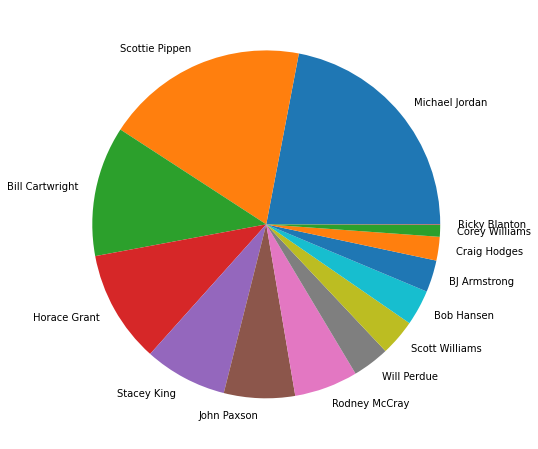

Miami, 2010-2011, 1.342881292618329


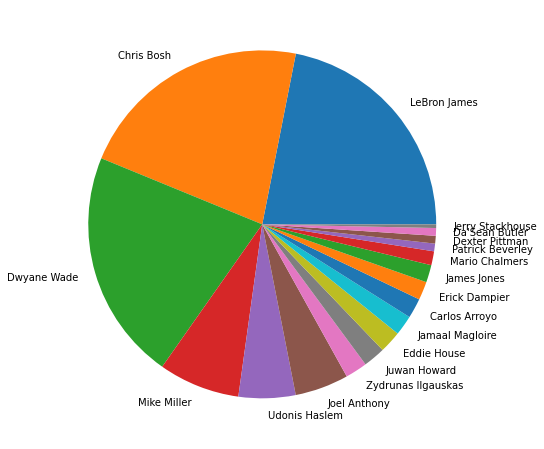

Golden State, 2015-2016, 0.8776202924585763


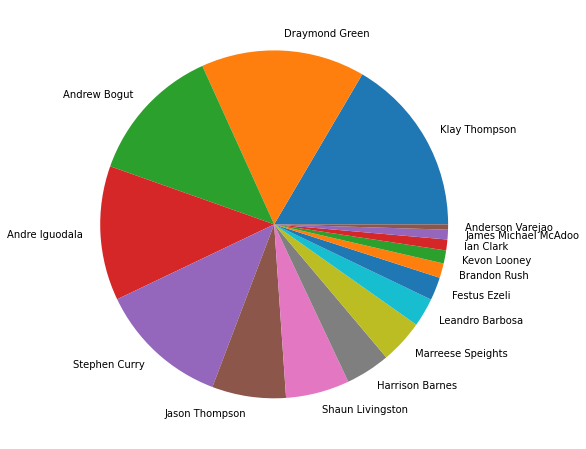

LA Lakers, 2019-2020, 1.4848159577370332


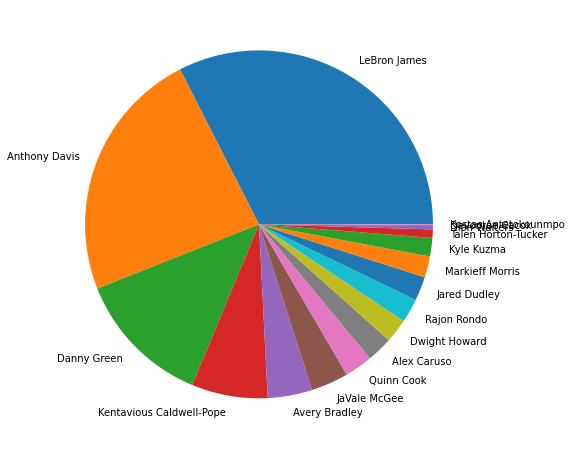

In [481]:
from scipy.stats import variation
nbaSalaryData = loadData()

plotTeamSalaries(nbaSalaryData, "1992-1993", "Chicago")
plotTeamSalaries(nbaSalaryData, "2010-2011", "Miami")
plotTeamSalaries(nbaSalaryData, "2015-2016", "Golden State")
plotTeamSalaries(nbaSalaryData, "2019-2020", "LA Lakers")

<a id='league-average-distribution'></a>
### League Average Salary Distribution Over Time

Initially I decided to use the standard deviation to measure how salaries are distributed. The standard deviation represents the degree to which salaries on a team deviate from the mean salary. A larger standard deviation means players salaries are distributed less evenly. However, since total salaries have risen a lot since 1990, the average standard deviation will increase over time simply due to salary increases. This is not what we are interested in. This is why I decided to use the [relative standard deviation, or coefficient of variation](https://en.wikipedia.org/wiki/Coefficient_of_variation), which is the standard deviation divided by the mean. This will normalize our salaries so that they can be compared across different periods.

<function matplotlib.pyplot.show(close=None, block=None)>

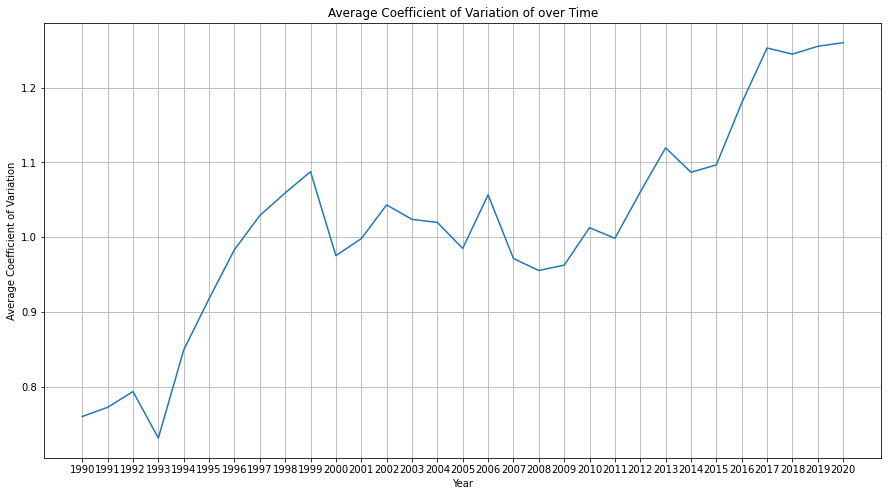

In [483]:
import matplotlib.pyplot as plt
from scipy.stats import variation

nbaSalaryData = loadData()

avgRsd = []
years = []

for year in nbaSalaryData.keys():
    teamRsd = []
    years.append(year.split("-")[0])
    
    for team in nbaSalaryData[year].keys():
        rsd = variation(getSalaries(nbaSalaryData, year, team))
        teamRsd.append(rsd)
    avgRsd.append(sum(teamRsd)/ len(teamRsd))

plt.rcParams['figure.figsize'] = [15, 8]
plt.plot(years, avgRsd)
plt.title("Average Coefficient of Variation of over Time")
plt.xlabel("Year")
plt.ylabel("Average Coefficient of Variation")
plt.grid(True)
plt.show

The year shown on the x-axis is shortened to the the season's start year for legibility. So '1990' represents the 1990-1991 season. The average coefficient of variation is the average for all teams in the league for the given year.

This graph shows that the original hypothesis was correct - the difference between salaries on teams is getting larger over time. Futhermore, this trend starts around the same time "The Big 3" (Lebron James, Chris Bosh, and Dwayne Wade) teamed up in Miami in 2010-2011.

In [49]:
import pandas as pd

nbaSalaryData = loadData()
# df = pd.DataFrame.from_dict(pd.json_normalize(nbaSalaryData), orient='columns')
# df.head()
# df = pd.read_json("data/nbaSalaryData.json")
# df.head()
# df = pd.json_normalize(nbaSalaryData, )
# df.head()

In [ ]:
# url = 'https://stats.nba.com/stats/leaguestandings'
# testp = requests.get(url)

In [ ]:
# print(testp.status_code)
# tests = BeautifulSoup(testp.content, 'html.parser')
# print(tests)

In [76]:
from nba_api.stats.endpoints import leaguestandings
# standings = leaguestandings.LeagueStandings(season="1990-91").get_json()
standings = leaguestandings.LeagueStandings(season="1992-93").get_data_frames()[0]
pd.set_option('display.max_columns', None)
standings.head()

,LeagueID,SeasonID,TeamID,TeamCity,TeamName,Conference,ConferenceRecord,PlayoffRank,ClinchIndicator,Division,DivisionRecord,DivisionRank,WINS,LOSSES,WinPCT,LeagueRank,Record,HOME,ROAD,L10,Last10Home,Last10Road,OT,ThreePTSOrLess,TenPTSOrMore,LongHomeStreak,strLongHomeStreak,LongRoadStreak,strLongRoadStreak,LongWinStreak,LongLossStreak,CurrentHomeStreak,strCurrentHomeStreak,CurrentRoadStreak,strCurrentRoadStreak,CurrentStreak,strCurrentStreak,ConferenceGamesBack,DivisionGamesBack,ClinchedConferenceTitle,ClinchedDivisionTitle,ClinchedPlayoffBirth,EliminatedConference,EliminatedDivision,AheadAtHalf,BehindAtHalf,TiedAtHalf,AheadAtThird,BehindAtThird,TiedAtThird,Score100PTS,OppScore100PTS,OppOver500,LeadInFGPCT,LeadInReb,FewerTurnovers,PointsPG,OppPointsPG,DiffPointsPG,vsEast,vsAtlantic,vsCentral,vsWest,vsPacific,vsMidwest,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,PreAS,PostAS
0,00,21992,1610612756,Phoenix,Suns,West,40-14,1,,Pacific,21-9,1,62,20,0.756,None,62-20,35-6,27-14,None,None,None,0-0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0.0,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,113.4,106.7,6.7,22-6,12-2,10-4,40-14,21-9,19-5,None,None,None,None,None,None,None,None,None,None,None,None,38-10,24-10
1,00,21992,1610612752,New York,Knicks,East,42-14,1,,Atlantic,23-5,1,60,22,0.732,None,60-22,37-4,23-18,None,None,None,0-0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0.0,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,101.6,95.4,6.2,42-14,23-5,19-9,18-8,9-5,9-3,None,None,None,None,None,None,None,None,None,None,None,None,34-16,26-6
2,00,21992,1610612760,Seattle,SuperSonics,West,38-16,2,,Pacific,22-8,2,55,27,0.671,None,55-27,33-8,22-19,None,None,None,0-0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,7.0,7.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,108.3,101.3,7.0,17-11,10-4,7-7,38-16,22-8,16-8,None,None,None,None,None,None,None,None,None,None,None,None,33-17,22-10
3,00,21992,1610612741,Chicago,Bulls,East,39-17,2,,Central,19-9,1,57,25,0.695,None,57-25,31-10,26-15,None,None,None,0-0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,3.0,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,105.2,98.9,6.3,39-17,20-8,19-9,18-8,11-3,7-5,None,None,None,None,None,None,None,None,None,None,None,None,35-17,22-8
4,00,21992,1610612745,Houston,Rockets,West,36-18,2,,Midwest,19-7,1,55,27,0.671,None,55-27,31-10,24-17,None,None,None,0-0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,7.0,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,104.0,99.8,4.2,19-9,9-5,10-4,36-18,17-11,19-7,None,None,None,None,None,None,None,None,None,None,None,None,30-21,25-6


In [90]:
standings[["TeamCity", "TeamName", "WinPCT"]]

,TeamCity,TeamName,WinPCT
0,Phoenix,Suns,0.756
1,New York,Knicks,0.732
2,Seattle,SuperSonics,0.671
3,Chicago,Bulls,0.695
4,Houston,Rockets,0.671
5,Cleveland,Cavaliers,0.659
6,Portland,Trail Blazers,0.622
7,Boston,Celtics,0.585
8,Charlotte,Hornets,0.537
9,San Antonio,Spurs,0.598


In [89]:
from nba_api.stats.endpoints import commonplayoffseries
from nba_api.stats.endpoints import playoffpicture
from nba_api.stats.endpoints import leaguegamelog

# playoffs = commonplayoffseries.CommonPlayoffSeries(season="1992-93").get_data_frames()
# playoffs

# playoffs = playoffpicture.PlayoffPicture(season_id=22019).get_data_frames()
# playoffs

playoffs = leaguegamelog.LeagueGameLog(season="1992-93", season_type_all_star="Playoffs").get_data_frames()[0]
playoffs.tail()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
147,41992,1610612756,PHX,Phoenix Suns,0049200074,1993-06-16,PHX @ CHI,L,240,38,79,0.481,3,8,0.375,26,33,0.788,8,26,34,20,6,3,10,28,105,-6,0
148,41992,1610612756,PHX,Phoenix Suns,0049200075,1993-06-18,PHX @ CHI,W,240,42,83,0.506,3,10,0.300,21,26,0.808,14,31,45,24,6,4,11,16,108,10,0
149,41992,1610612741,CHI,Chicago Bulls,0049200075,1993-06-18,CHI vs. PHX,L,240,37,79,0.468,8,18,0.444,16,24,0.667,8,27,35,20,6,4,9,22,98,-10,0
150,41992,1610612756,PHX,Phoenix Suns,0049200076,1993-06-20,PHX vs. CHI,L,240,32,82,0.390,4,11,0.364,30,36,0.833,18,29,47,20,5,9,9,21,98,-1,0
151,41992,1610612741,CHI,Chicago Bulls,0049200076,1993-06-20,CHI @ PHX,W,240,39,82,0.476,10,14,0.714,11,20,0.550,12,27,39,24,6,2,8,26,99,1,0
